- https://www.ruder.io/optimizing-gradient-descent/

## basics

- DECOUPLED WEIGHT DECAY REGULARIZATION
    - https://arxiv.org/pdf/1711.05101.pdf
    - SGD: L2 reg == weight decay 
    - Adaptive Gradient：
        - Adam
- L2 reg 、weight decay 都是避免过拟合的手段
    - 过拟合的一个标志就是一些 weight 的取值过大；
        - 如一般 weight value range between [-5, 5]，
        - 但 overfitting 时，weight value 可能会是 25 或者  -32
    - 在数值上，L2 reg 与 weight decay 作用都是会降低 weight 的幅值（magnitude）

$$
\begin{split}
&w_t=w_{t-1}-\Delta w\\
&w_t=0.98w_t=w_t-0.02w_t
\end{split}
$$

## L2 reg ==? weight decay

### SGD

- L2 reg

$$
\begin{split}
&\mathcal L=\mathcal L_{\text{error}} + \frac\lambda2 ||w||^2\\
&w=w-\alpha \frac{\partial \mathcal L}{\partial w}-\alpha\lambda w
\end{split}
$$

- weight decay 

$$
\begin{split}
&\mathcal L=\mathcal L_{\text{error}} \\
&w=w-\alpha \frac{\partial \mathcal L}{\partial w}-\alpha\lambda w
\end{split}
$$

### SGD with Momentum

- L2 reg

$$
\begin{split}
&\mathcal L=\mathcal L_{\text{error}} + \frac\lambda2 ||w||^2\\
&v_t=\beta v_{t-1}+(1-\beta)\left(\frac{\partial \mathcal L}{\partial w}+\lambda w\right)\\
&w=w-\alpha v_t
\end{split}
$$

- weight decay

$$
\begin{split}
&\mathcal L=\mathcal L_{\text{error}} \\
&v_t=\beta v_{t-1}+(1-\beta)\left(\frac{\partial \mathcal L}{\partial w}\right)\\
&w=w-\alpha v_t-\alpha\lambda w
\end{split}
$$

### Adam => AdamW

- Adam
$$
\begin{split}
&\mathcal L=\mathcal L_{\text{error}} + \frac\lambda2 ||w||^2\\
&m_t=\beta_1 m_{t-1}+(1-\beta_1)\left(\frac{\partial \mathcal L}{\partial w}+\lambda w\right)\\
&v_t=\beta_2 v_{t-1} + (1-\beta_2)\left(\frac{\partial \mathcal L}{\partial w}+\lambda w\right)^2\\
&w=w-\alpha\frac{m_t}{\sqrt{v_t}+\epsilon}
\end{split}
$$

- AdamW

    $$
    \begin{split}
    &\mathcal L=\mathcal L_{\text{error}}\\
    &m_t=\beta_1 m_{t-1}+(1-\beta_1)\left(\frac{\partial \mathcal L}{\partial w}\right)\\
    &v_t=\beta_2 v_{t-1} + (1-\beta_2)\left(\frac{\partial \mathcal L}{\partial w}\right)^2\\
    &w=w-\alpha\frac{m_t}{\sqrt{v_t}+\epsilon} - \alpha\lambda w
    \end{split}
    $$

    - 引入 Bias Correction: $\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \hat{v}_t = \frac{v_t}{1 - \beta_2^t}$
        - 后续更新
            - $\Delta W_t' = \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$
            - $W_t = W_{t-1} - (\Delta W_t' + \lambda W_{t-1})$
        - 由于 $m_0, v_0$ 初始均为 0，，在训练初期，它们会偏向于 0，这一步是为了修正这个偏差。
            - $\beta_1=0.9$
            - $t=1$：$m_1 = \beta_1 m_0 + (1 - \beta_1) g_1 = 0.9 \cdot 0 + 0.1 \cdot g_1 = 0.1 \cdot g_1$，计算出的动量 $m_1$ 只有真实梯度 $g_1$ 的 10%，被初始的 $m_0=0$ 严重地 biased towards 0；
            - $t=2$：$m_2 = \beta_1 m_1 + (1 - \beta_1) g_2 = 0.9 \cdot (0.1 \cdot g_1) + 0.1 \cdot g_2 = 0.09 \cdot g_1 + 0.1 \cdot g_2$
            - 引入 $\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$
                - $t=1$：分母 $1 - \beta_1^1 = 1 - 0.9 = 0.1$，$\hat{m}_1 = \frac{m_1}{0.1} = \frac{0.1 \cdot g_1}{0.1} = g_1$
                - $t=2$：分母 $1 - \beta_1^2 = 1 - 0.81 = 0.19$，$\hat{m}_2 = \frac{m_2}{0.19} = \frac{0.09 \cdot g_1 + 0.1 \cdot g_2}{0.19}$
                - 当 t 很大时 (比如 t=100)：$\beta_1^t$ 约等于 0，分母约等于 1；

## L2 tutorial

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
# default: 100.0
plt.rcParams['figure.dpi'] = 120
seed = 247
torch.manual_seed(seed)

In [9]:
xs = torch.linspace(0, 1, 30)
ys = 0.5 + 0.4*torch.sin(2*np.pi*xs) + torch.randn(xs.size())*0.05

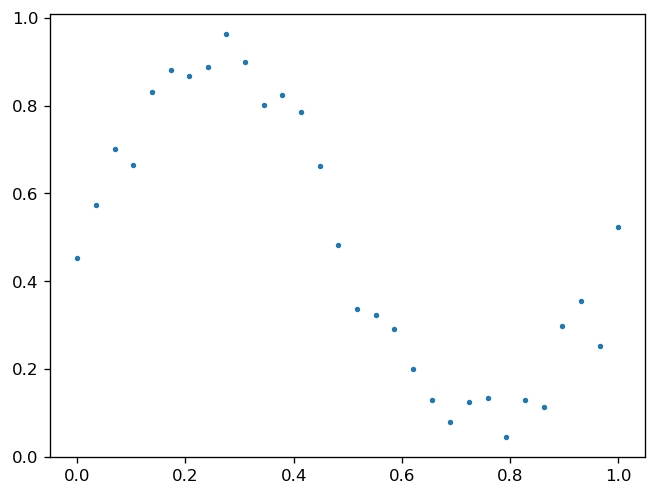

In [17]:
plt.scatter(xs.numpy(), ys.numpy(), label='data', s=5)

In [27]:
class NN(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.ln1 = torch.nn.Linear(1, dim_h)
        self.ln2 = torch.nn.Linear(dim_h, 1)
    def forward(self, x):
        return self.ln2(torch.nn.ReLU()(self.ln1(x)))

In [44]:
model = NN(300)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for _ in tqdm(range(10000)):
    y_pred = model(xs.reshape(-1, 1))
    loss = loss_fn(y_pred, ys.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


100%|██████████| 10000/10000 [00:05<00:00, 1834.22it/s]


(array([ 2.,  9., 30., 57., 42., 60., 32., 33., 25., 10.]),
 array([-1.73142874, -1.43855548, -1.14568222, -0.85280901, -0.55993575,
        -0.26706249,  0.02581077,  0.31868401,  0.61155725,  0.90443051,
         1.19730377]),
 <BarContainer object of 10 artists>)

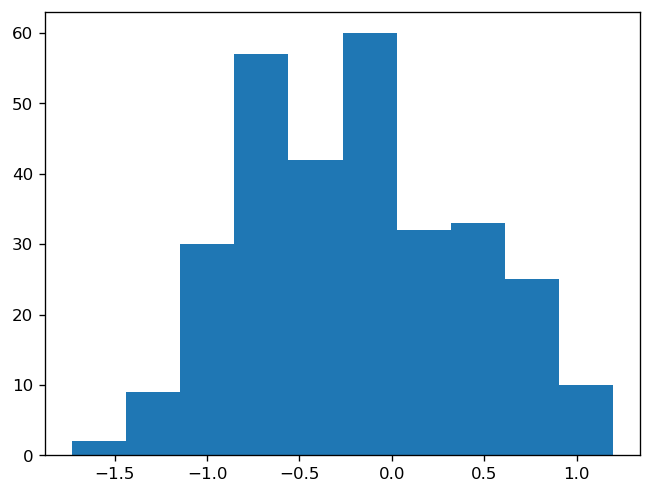

In [46]:
plt.hist(model.ln1.weight.detach().numpy())

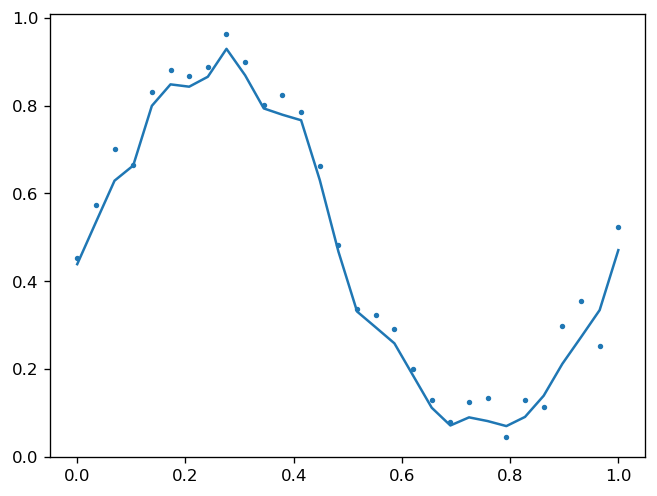

In [31]:
x_test = torch.linspace(0, 1, 30)
y_test = model(x_test.reshape(-1, 1)).squeeze()
plt.scatter(xs.numpy(), ys.numpy(), label='data', s=5)
plt.plot(x_test.numpy(), y_test.detach().numpy())

In [32]:
def weights_norm(model):
    norm = 0
    for para in model.parameters():
        norm += torch.sum(para ** 2)
    norm = torch.sqrt(norm)
    return norm

In [33]:
weights_norm(model)

tensor(15.0379, grad_fn=<SqrtBackward0>)

In [36]:
model2 = NN(300)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
l2_reg_lambda = 0.0001

for _ in tqdm(range(10000)):
    y_pred = model2(xs.reshape(-1, 1))
    l2_reg = 0
    for param in model2.parameters():
        l2_reg += torch.sum(param ** 2)
    
    loss = loss_fn(y_pred, ys.unsqueeze(1)) + l2_reg_lambda * l2_reg
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 10000/10000 [00:07<00:00, 1364.63it/s]


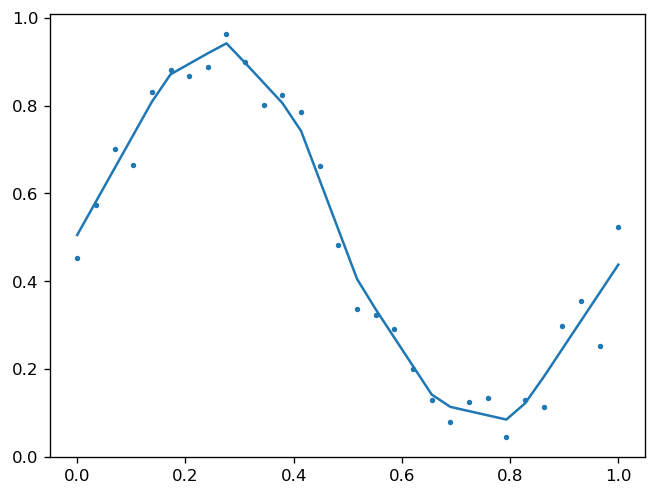

In [37]:
x_test = torch.linspace(0, 1, 30)
y_test = model2(x_test.reshape(-1, 1)).squeeze()
plt.scatter(xs.numpy(), ys.numpy(), label='data', s=5)
plt.plot(x_test.numpy(), y_test.detach().numpy())

In [38]:
weights_norm(model2)

tensor(4.8838, grad_fn=<SqrtBackward0>)

(array([  1.,   3.,   6.,  14.,  13., 245.,  12.,   4.,   1.,   1.]),
 array([-1.05048752, -0.86233264, -0.67417777, -0.48602292, -0.29786804,
        -0.10971317,  0.0784417 ,  0.26659659,  0.45475143,  0.64290631,
         0.83106118]),
 <BarContainer object of 10 artists>)

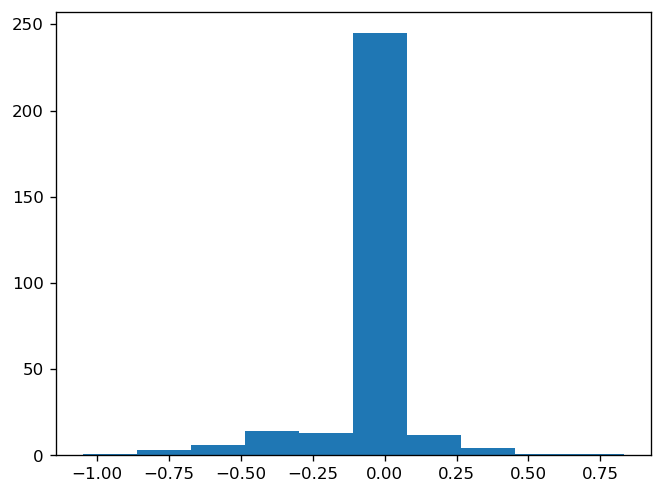

In [43]:
plt.hist(model2.ln1.weight.detach().numpy())